#  Прогнозирование заказов такси

_____
**Описание исследования.**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
_____
**Условия исследования:**

Значение метрики RMSE на тестовой выборке должно быть не больше 48.


______

**Данное исследование разделим на несколько частей.**

- Загрузка данных и их ресемплирование по одному часу.
- Анализ данных.
- Обучение разных моделей с различными гиперпараметрами, создание тестовой выборки размером 10% от исходных данных.
- Проверка данных на тестовой выборке.

### Библиотеки и окружение.

In [ ]:
!pip install catboost -q
!pip install lightgbm -q

In [ ]:
!pip install matplotlib==3.8.4 -q

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!pip install scikit-learn==1.4.0 -q

In [ ]:
!pip install seaborn==0.13.2 -q

In [ ]:
import xgboost as xgb

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from matplotlib import rcParams

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from lightgbm import LGBMRegressor
import lightgbm as lgb
import time
import scipy.stats as stats

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
import os

Переменные:

In [ ]:
RANDOM_STATE = 42

## Подготовка

In [ ]:
# Загрузка данных
pth1 = '/datasets/taxi.csv'
pth2 = 'datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=[0], index_col=0).sort_index()
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=[0], index_col=0).sort_index()
else:
    print('Something is wrong')

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.index.is_monotonic_increasing

True

Датасет монотонный.

In [ ]:
df_h = df.resample('1H').sum()

## Анализ

In [ ]:
df_h['rolling_mean'] = df_h['num_orders'].rolling(24).mean()
df_h['dayofweek'] = df_h.index.dayofweek
df_h['hour'] = df_h.index.hour

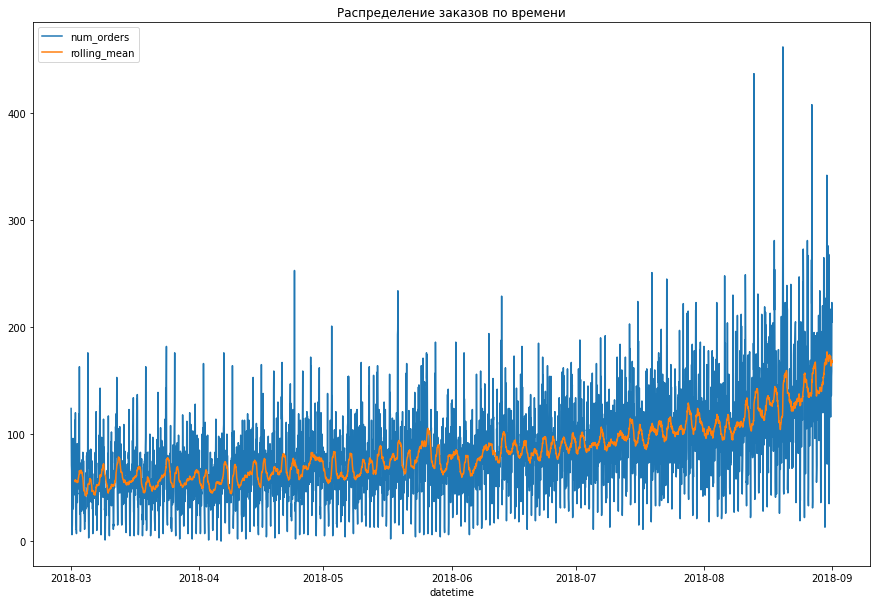

In [ ]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=df_h[['num_orders', 'rolling_mean']], dashes=False)
plt.title('Распределение заказов по времени')
plt.show()

Среднее значение плавно растёт.

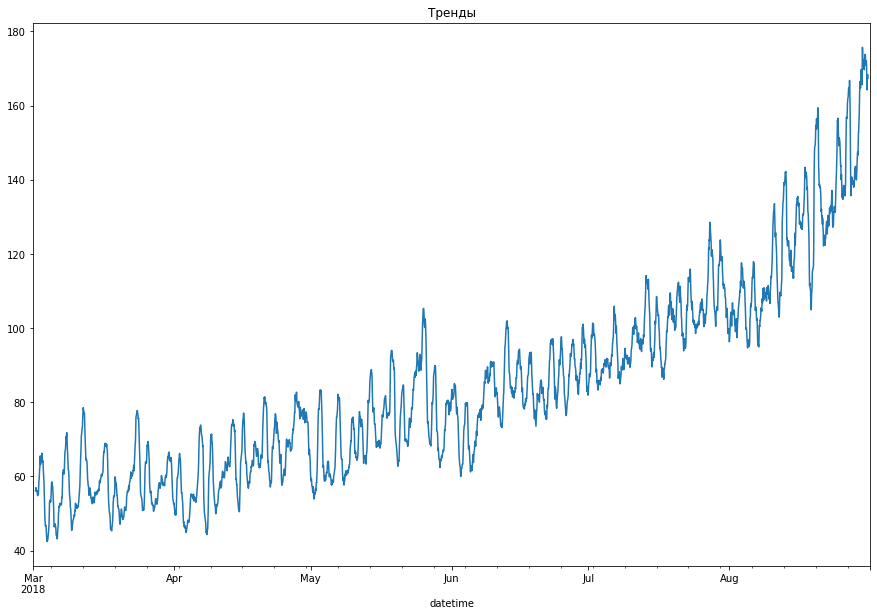

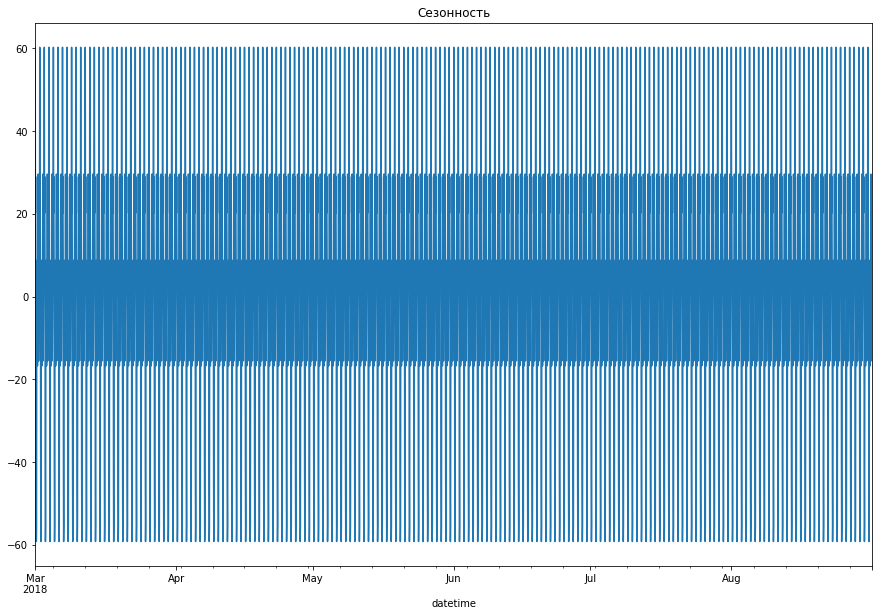

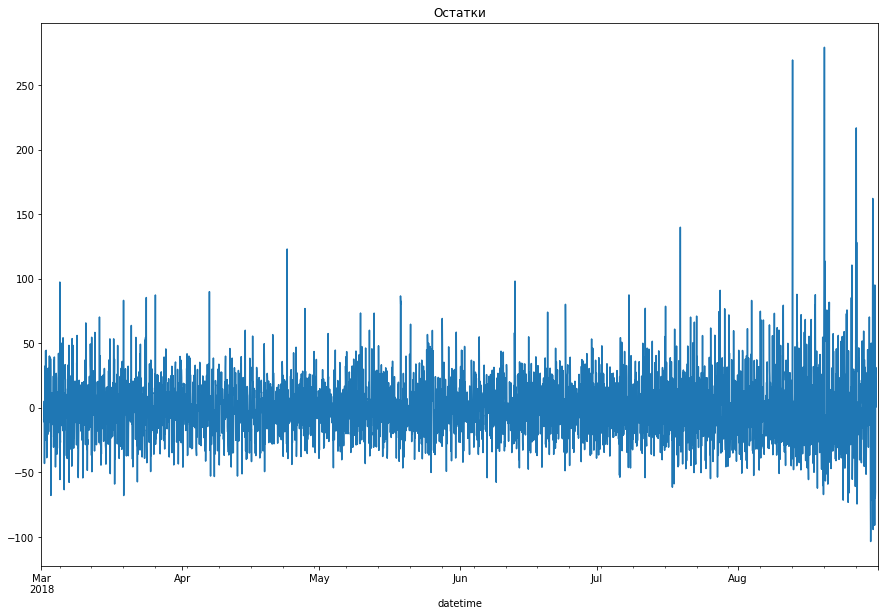

In [ ]:

decomposed_num = seasonal_decompose(df_h['num_orders'])
plt.figure(figsize=(15, 10))
decomposed_num.trend.plot()
plt.title('Тренды')
plt.show()
plt.figure(figsize=(15, 10))
decomposed_num.seasonal.plot()
plt.title('Сезонность')
plt.show()
plt.figure(figsize=(15, 10))
decomposed_num.resid.plot()
plt.title('Остатки')
plt.show()

Наблюдаем относительно большое количество шумов в августе, следовательно при анализе остатков после обучения модели будет наблюдаться хвост гистограммы, также будет ощутимая разница в метриках на кросс-валидационной и на тестовой.

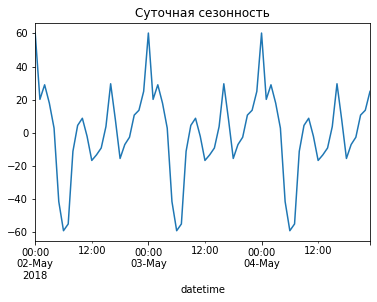

In [ ]:
decomposed_num.seasonal['2018-05-2':'2018-05-4'].plot()
plt.title('Суточная сезонность')
plt.show()

В сутках есть сезонность- в утренние часы меньше всего заказов, а к ночи больше всего заказов.

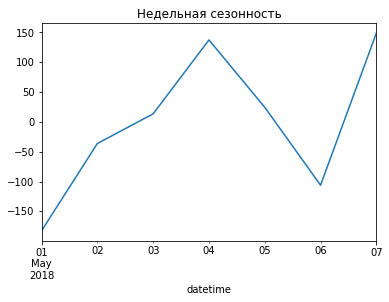

In [ ]:
df_d = df.resample('1D').sum()
decomposed = seasonal_decompose(df_d['num_orders'])
decomposed.seasonal['2018-05-1':'2018-05-7'].plot()
plt.title('Недельная сезонность')
plt.show()

Недельная сезонность также прослеживается.

### Промежуточный вывод:


Исходя из сезонности для постоения модели используем признаки:
- Месяц
- День недели
- Число
- Часы




## Обучение

In [ ]:
def make_features(df_h, max_lag, rolling_mean_size):
    df_h['hour'] = df_h.index.hour
    df_h['day'] = df_h.index.day
    df_h['dayofweek'] = df_h.index.dayofweek
    df_h['month'] = df_h.index.month

    for lag in range(1, max_lag + 1):
        df_h['lag_{}'.format(lag)] = df_h['num_orders'].shift(lag)

    df_h['rolling_mean'] = df_h['num_orders'].shift().rolling(rolling_mean_size).mean()
    df_h.dropna(inplace=True)
    return df_h


In [ ]:
make_features(df_h, 24, 7)

train, test = train_test_split(df_h, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

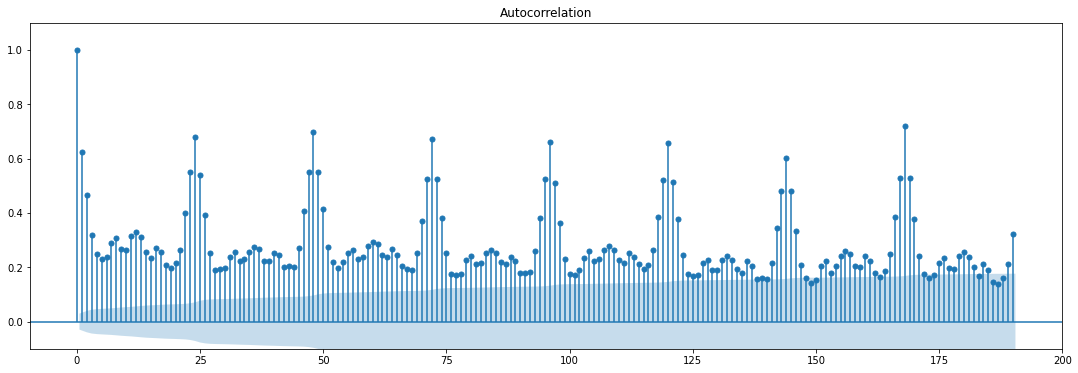

In [ ]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()


In [ ]:
print(f'Размер тестовой выборки: ', f'{(len(target_test)/len(df_h)):.0%}')
print(f'Размер тренировочной выборки: ', f'{(len(features_train)/len(df_h)):.0%}')

Размер тестовой выборки:  10%
Размер тренировочной выборки:  90%


In [ ]:
pipe_final = Pipeline([
    ('preprocessor', StandardScaler()),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])


In [ ]:
param_grid = [
    {
        'models': [CatBoostRegressor(loss_function="RMSE", iterations=150, verbose=False)]
    },
    {
        'models': [lgb.LGBMRegressor()]
    },
    {
        'models': [LinearRegression()]
    },
    {
        'models': [lgb.LGBMRegressor()],
        'models__n_estimators': [100, 200, 300],
        'models__max_depth': [3, 5, 7]
    }
]
tscv = TimeSeriesSplit(n_splits=5)

g_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=tscv,
    verbose=0,
    #n_iter=5,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    error_score='raise'
)


%time g_search.fit(features_train, target_train)



CPU times: user 1min 31s, sys: 1.17 s, total: 1min 32s
Wall time: 1min 37s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('models',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [<catboost.core.CatBoostRegressor object at 0x7f120a068400>]},
                         {'models': [LGBMRegressor()]},
                         {'models': [LinearRegression()]},
                         {'models': [LGBMRegressor()],
                          'models__max_depth': [3, 5, 7],
                          'models__n_estimators': [100, 200, 300]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
print('Лучшая модель и её параметры:\n\n', g_search.best_estimator_)
print ('Метрика RMSE лучшей модели на кросс-валидации:', g_search.best_score_*(-1))


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor', StandardScaler()),
                ('models', LGBMRegressor(max_depth=5))])
Метрика RMSE лучшей модели на кросс-валидации: 24.61322098491123


## Тестирование

In [ ]:
results = pd.DataFrame(g_search.cv_results_)

In [ ]:
y_test_pred = g_search.best_estimator_.predict(features_test)
print(f'Метрика RMSE на тестовой выборке: {sqrt(mean_squared_error(target_test, y_test_pred))}')

Метрика RMSE на тестовой выборке: 39.85128768333165


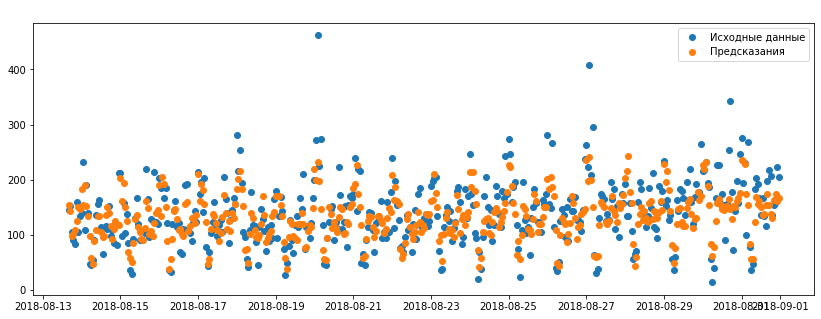

In [ ]:
plt.figure(figsize=(14, 5))
plt.scatter(y=target_test, x=target_test.index, label='Исходные данные')
plt.scatter(y=y_test_pred, x=target_test.index, label='Предсказания')
plt.legend(loc='upper right')
plt.title(' ')
plt.show()

In [ ]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]


In [ ]:
print("RMSE оценики предыдущим значением ряда:",
      sqrt(mean_squared_error(test['num_orders'], pred_previous)))


RMSE оценики предыдущим значением ряда: 58.881776776551476


## Вывод

**Выделена лучшая модель: LGBMRegressor(max_depth=5)**

In [ ]:
g_search.best_estimator_

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('models', LGBMRegressor(max_depth=5))])

**Метрика RMSE лучшей модели на кросс-валидационной выборке равна 24.59**

**Метрика RMSE лучшей модели на тестовой выборке равна 39.9**